# Test for SegFormer usage

## Libraries

In [1]:
! pip install -U \
  transformers==4.41.2 \
  datasets==2.19.0 \
  accelerate==1.7.0

!pip install --upgrade datasets

  Using cached datasets-2.19.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-2.19.0-py3-none-any.whl (542 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.19.0
    Uninstalling datasets-2.19.0:
      Successfully uninstalled datasets-2.19.0


In [2]:
import os
# os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
from transformers import pipeline
from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation,
    Trainer,
    TrainingArguments,
    default_data_collator,
)
import transformers, accelerate, datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, DatasetDict
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
import torch

2025-06-03 00:11:00.526747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748880660.543400  799738 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748880660.548723  799738 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748880660.561291  799738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748880660.561309  799738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748880660.561311  799738 computation_placer.cc:177] computation placer alr

## Run the built-in segmentation pipeline

In [ ]:
# Load a SegFormer-B0 model already fine-tuned on ADE20K
segmenter = pipeline(
    "image-segmentation",
    model="optimum/segformer-b0-fintuned-ade-512-512",
) # uses ONNXRuntime under the hood for speed :contentReference[oaicite:1]{index=1}

# Segment your image (PIL Image, NumPy array, or URL)
output = segmenter("path/to/your/image.jpg")

# output is a list of dicts: [{"label":"water","mask":<PIL.Image>}, ...]
for obj in output:
    print(obj["label"], obj["score"])
    obj["mask"].save(f"{obj['label']}.png")

## Fine-tune SegFormer on Datasets

### Dataset preparation

In [ ]:
# Dataset on huggingface (should prepare from online download)
# Structure a dataset dict or use the datasets library to load images + mask PNGs, with columns {"image":…, "label":…}

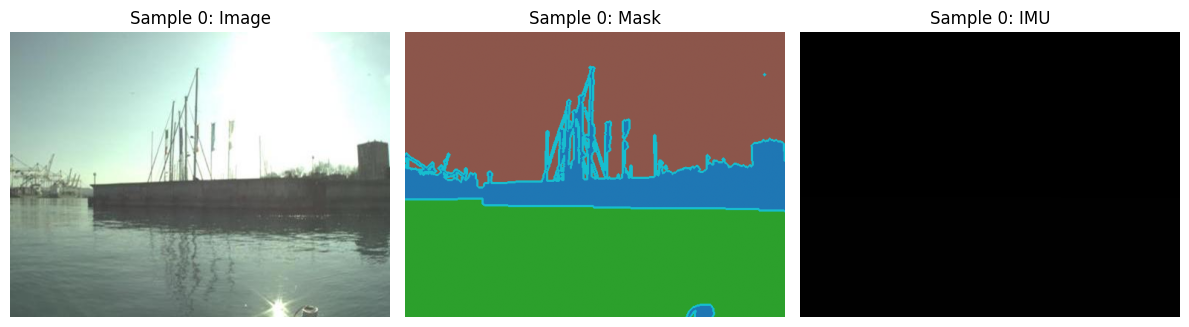

In [4]:
ds = load_dataset("Wilbur1240/MaSTr1325_512x384", split="train")

def show_sample(sample, idx):
    img = sample["image"].convert("RGB")
    msk = sample["mask"].convert("L")
    imu = sample["imu"].convert("RGB")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title(f"Sample {idx}: Image")
    axes[0].axis("off")

    axes[1].imshow(msk, cmap="tab10", vmin=0, vmax=4)
    axes[1].set_title(f"Sample {idx}: Mask")
    axes[1].axis("off")

    axes[2].imshow(imu)
    axes[2].set_title(f"Sample {idx}: IMU")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

N = 1
for i in range(N):
    show_sample(ds[i], i)

In [5]:
def convert_mask(example):
    label_array = np.array(example["mask"].convert("L"), dtype=np.uint8)
    example["label"] = label_array
    return example

ds = ds.map(convert_mask)

In [ ]:
print(ds.features)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_label(sample, idx=0):
    image = sample["image"]
    label = np.array(sample["label"])

    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Sample {idx}: Image")
    plt.axis("off")

    # Label Mask
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="tab10", vmin=0, vmax=3)  # vmin/vmax controls color mapping
    plt.title(f"Sample {idx}: Mask (label)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example: show the first sample
visualize_label(ds[0], idx=0)


### Preprocess & tokenize

In [7]:
image_processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

def preprocess(example):
    processed = image_processor(example["image"], return_tensors="pt")
    label_tensor = torch.tensor(example["label"], dtype=torch.long)
    label_tensor = torch.where(
        (label_tensor >= 0) & (label_tensor <= 2),  # 3 = num_labels
        label_tensor,
        torch.tensor(255)
    )
    return {
        "pixel_values": processed["pixel_values"].squeeze(0), # shape: [3, H, W]
        "labels": label_tensor, # shape: [H, W]
    }

tokenized = ds.map(
    preprocess, batched=True, remove_columns=ds.column_names, batch_size=16
)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CLASS_NAMES = {0: "sky", 1: "obstacle", 2: "sea", -100: "None"}

def visualize_labeled_mask(label):
    label = np.array(label)
    masked_label = np.ma.masked_equal(label, -100)
    plt.imshow(masked_label, cmap="tab10", vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2])
    plt.clim(-0.5, 2.5)
    plt.title("Segmentation Mask (sky, obstacle, sea)")
    plt.axis("off")
    plt.show()

visualize_labeled_mask(tokenized[0]["labels"])

In [8]:
splits = tokenized.train_test_split(test_size=0.1, seed=42)
train_dataset = splits["train"]
valid_dataset = splits["test"]
tokenized = {
    "train": train_dataset,
    "validation": valid_dataset,
}

In [ ]:
tokenized

In [ ]:
import numpy as np
from collections import Counter

# Flatten all labels in a sample and check unique values
def inspect_labels(dataset, n=10):
    for i in range(n):
        label = dataset[i]["labels"]
        flat = np.array(label).flatten()
        print(f"Sample {i} unique label values:", sorted(set(flat)))

In [ ]:
inspect_labels(tokenized["train"])

### Setup Trainer and train

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=3,                    # your classes: water/sky/obstacle
    ignore_mismatched_sizes=True,    # in case you change decoder head size
)

args = TrainingArguments(
    "segformer-maritime",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    logging_steps=50,
    push_to_hub=False,
    fp16=False
)
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=default_data_collator,
    tokenizer=image_processor,
)

In [ ]:
print(model.config.decoder_hidden_size)
print(model.segformer.config)

In [ ]:
trainer.train()

## Inference

### Load from checkpoint

In [9]:
image_processor = SegformerImageProcessor.from_pretrained("./segformer-maritime/checkpoint-2980")
model = SegformerForSemanticSegmentation.from_pretrained(
    "./segformer-maritime/checkpoint-2980",
    num_labels=3,
    ignore_mismatched_sizes=True,
)

model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

### inference functions

In [13]:
def predict_single_batch(model, batch, image_processor):
    model.eval()
    with torch.no_grad():
        pixel_values = batch["pixel_values"]
        if isinstance(pixel_values, list):
            pixel_values = torch.tensor(pixel_values)
        elif isinstance(pixel_values, np.ndarray):
            pixel_values = torch.from_numpy(pixel_values)

        if pixel_values.ndim == 3:
            pixel_values = pixel_values.unsqueeze(0)
        
        pixel_values = pixel_values.to(dtype=torch.float32, device=model.device)
        
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
    return preds.cpu().numpy()

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

def visualize_prediction(image, label, pred, id2label=None):
    image = to_numpy(image)
    label = to_numpy(label)
    pred = to_numpy(pred)

    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = np.transpose(image, (1, 2, 0))
        image = (image + 1.0) / 2.0
        image = np.clip(image, 0, 1)

    if label.ndim == 1:
        side = int(np.sqrt(label.shape[0]))
        label = label.reshape(side, side)

    print("Image shape: ", image.shape)
    print("Label shape: ", label.shape)
    print("Pred shape: ", pred.shape)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)  # image shape: [3, H, W]
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='tab20')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='tab20')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Image shape:  (512, 512, 1)
Label shape:  (512, 1)
Pred shape:  (128, 128)


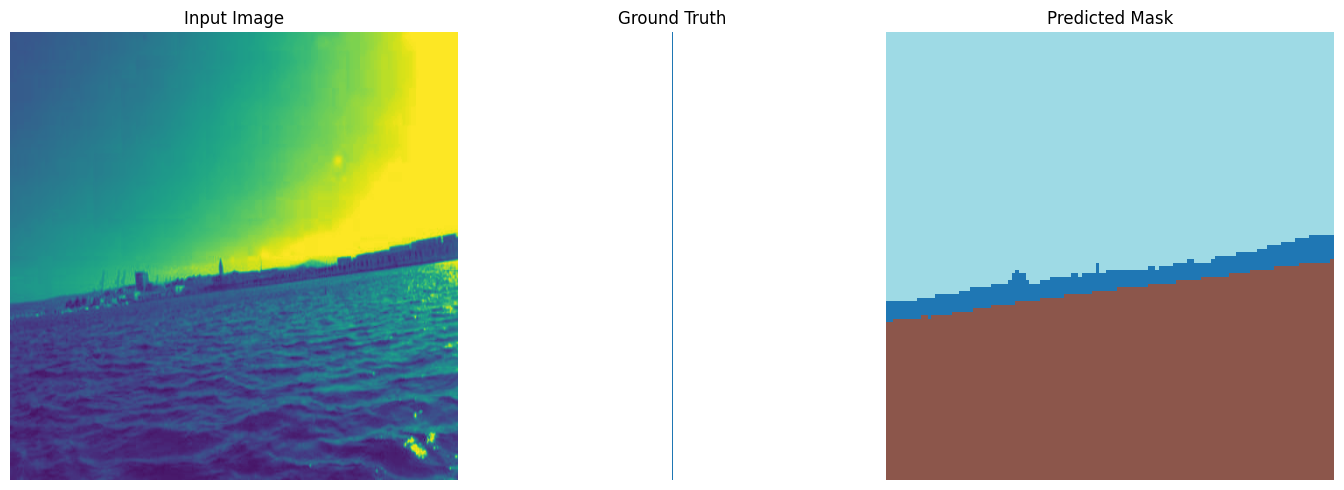

In [14]:
from torch.utils.data import DataLoader

# tokenized["validation"].set_format(type="torch", columns=["pixel_values", "labels"])
val_loader = DataLoader(tokenized["validation"], batch_size=1)

for batch in val_loader:
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]
    
    # Predict
    preds = predict_single_batch(model, {"pixel_values": pixel_values}, image_processor)

    # Visualize
    visualize_prediction(
        pixel_values[0], 
        labels[0], 
        preds[0], 
        id2label=model.config.id2label
    )
    break  # Remove this to visualize all validation samples

## Evaluation

In [ ]:
def compute_metrics(preds, labels, num_classes, ignore_index=255):
    preds = preds.flatten()
    labels = labels.flatten()

    # Remove ignored index
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]

    total_pixels = len(labels)
    correct = (preds == labels).sum()
    accuracy = correct / total_pixels

    # IoU per class
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum()
        union = (pred_inds | label_inds).sum()
        if union == 0:
            ious.append(float('nan'))  # or 0.0 if you prefer
        else:
            ious.append(intersection / union)

    mean_iou = np.nanmean(ious)
    return {"accuracy": accuracy.item(), "mean_iou": mean_iou, "ious": ious}

In [ ]:
val_loader = DataLoader(tokenized["validation"], batch_size=1)

all_preds = []
all_labels = []
model.eval()

for batch in val_loader:
    pixel_values = batch["pixel_values"].to(model.device)
    labels = batch["labels"].squeeze(0).numpy()  # shape: [H, W]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits  # shape: [1, num_classes, H, W]
        preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    all_preds.append(preds)
    all_labels.append(labels)

In [ ]:
metrics = compute_metrics(
    preds=np.array(all_preds),
    labels=np.array(all_labels),
    num_classes=3,
    ignore_index=255
)

print("✅ Validation Accuracy:", metrics["accuracy"])
print("✅ Mean IoU:", metrics["mean_iou"])
print("✅ Per-Class IoU:", metrics["ious"])

In [ ]:
id2label = model.config.id2label
for cls_id, iou in enumerate(metrics["ious"]):
    name = id2label[str(cls_id)]
    print(f"{name:<10}: IoU = {iou:.4f}")